In [1]:
import ROOT

Welcome to JupyROOT 6.16/00


In [2]:
file = ROOT.TFile.Open("../output/Charmonium2018B_test/jpsi_charmonium_2018B.root")

mass = ROOT.RooRealVar("mass", "", 2.95, 3.25)
data = ROOT.RooDataSet("data", "", file.Jpsi, ROOT.RooArgSet(mass))


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

[#1] INFO:Eval -- RooAbsReal::attachToTree(mass) TTree Float_t branch mass will be converted to double precision


In [3]:
#Signal PDFs

## Signal PDF: Crystal ball and gaussian

yield_gauss = ROOT.RooRealVar("yield_gauss","", 1e5, 0, 1e6)
mean = ROOT.RooRealVar("mean", "", 3.09, 2.95, 3.25)
sigma_gauss = ROOT.RooRealVar("sigma gauss", "", 0.1, 0.000001, 1)

yield_cb = ROOT.RooRealVar("yield_cb","", 1e5, 0, 1e6)
sigma_cb = ROOT.RooRealVar("sigma cb", "", 0.1, 0.000001, 1)

alpha = ROOT.RooRealVar("alpha", "", 1.4, 0, 10)
n = ROOT.RooRealVar("n", "", 99, 0, 100)
n.setConstant(True)

gauss = ROOT.RooGaussian("gauss", "", mass, mean, sigma_gauss)
crystal_ball = ROOT.RooCBShape("crystal ball", "", mass, mean, sigma_cb, alpha, n)

In [4]:
# Background PDF
yield_back = ROOT.RooRealVar("yield_back", "", 1e4, 0, 1e5)
exp_coef = ROOT.RooRealVar("exp_coef", "", -3, -5, 5)

back_exp = ROOT.RooExponential("back_exp", "", mass, exp_coef)

In [5]:
# Model definition and fitting
model = ROOT.RooAddPdf("model", "", ROOT.RooArgList(gauss, crystal_ball, back_exp),
                       ROOT.RooArgList(yield_gauss, yield_cb, yield_back))

In [6]:
result = model.fitTo(data, ROOT.RooFit.Extended(True), ROOT.RooFit.Range(2.95, 3.25))

[#1] INFO:Eval -- RooRealVar::setRange(mass) new range named 'fit' created with bounds [2.95,3.25]
[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_model_data) constructing test statistic for sub-range named fit
[#1] INFO:Eval -- RooRealVar::setRange(mass) new range named 'NormalizationRangeForfit' created with bounds [2.95,3.25]
[#1] INFO:Eval -- RooRealVar::setRange(mass) new range named 'fit_nll_model_data' created with bounds [2.95,3.25]
[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_model_data) fixing interpretation of coefficients of any RooAddPdf to full domain of observables 
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (gauss,crystal ball,back_exp)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 

In [7]:
frame = mass.frame(ROOT.RooFit.Title("Jpsi"))
data.plotOn(frame)
model.plotOn(frame)
frame.Draw()

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) p.d.f was fitted in range and no explicit plot,norm range was specified, using fit range as default
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) only plotting range 'fit_nll_model_data'
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) p.d.f. curve is normalized using explicit choice of ranges 'fit_nll_model_data'


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


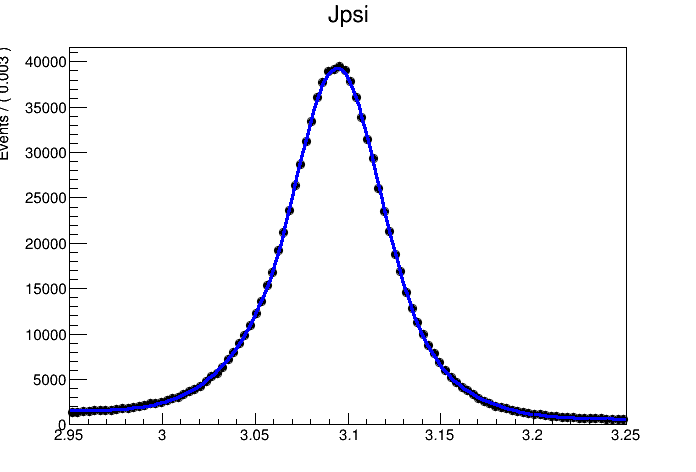

In [8]:
from ROOT import gROOT
gROOT.GetListOfCanvases().Draw()